# Amazon Fashion Metadata - XG BOOST REGRESSION

In [ ]:
# !pip install xgboost

In [1]:
import json
import pandas as pd
import zipfile
import ast
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Load the JSON Datafile

In [3]:

#Import datafile
file_path = "meta_AMAZON_FASHION.json"

records = []
bad_lines = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            bad_lines += 1
            continue  # skip malformed lines

print(f"Loaded {len(records)} records (skipped {bad_lines} bad lines)")

# Convert to DataFrame
df_meta = pd.DataFrame(records)

print("Rows:", df_meta.shape[0], "Columns:", df_meta.shape[1])
print(df_meta.head())


Loaded 186637 records (skipped 0 bad lines)
Rows: 186637 Columns: 16
                                               title                   brand  \
0  Slime Time Fall Fest [With CDROM and Collector...   Group Publishing (CO)   
1  XCC Qi promise new spider snake preparing men'...                     NaN   
2                 Magical Things I Really Do Do Too!       Christopher Manos   
3                 Ashes to Ashes, Oranges to Oranges  Flickerlamp Publishing   
4  Aether & Empire #1 - 2016 First Printing Comic...                     NaN   

                                             feature  \
0  [Product Dimensions:\n                    \n8....   
1                                                NaN   
2  [Package Dimensions:\n                    \n8....   
3  [Package Dimensions:\n                    \n8....   
4  [Package Dimensions:\n                    \n10...   

                                     rank         date        asin  \
0  13,052,976inClothing,Shoesamp;Jewelry(  

In [5]:
print("Duplicate ASINs:", df_meta["asin"].duplicated().sum())

Duplicate ASINs: 443


In [7]:
df_meta = df_meta.drop_duplicates(subset=["asin"], keep="first")

### Data Pre-processing

In [9]:
def clean_list(x):
    if isinstance(x, list):
        return "; ".join([str(i) for i in x])   # join safely
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return "; ".join([str(i) for i in parsed])
    except:
        return str(x)

In [11]:
list_cols = ['title','brand','feature','rank','date','asin','imageURL', 'imageURLHighRes','description','price','also_view','also_buy','fit','details','similar_item']

for col in list_cols:
    if col in df_meta.columns:
        df_meta[col] = df_meta[col].apply(
            lambda x: json.dumps(x) if isinstance(x, list) else x
        )


In [13]:
html_tag_pattern = re.compile(r'<[^>]+>')

def remove_html(x):
    x = str(x)
    if html_tag_pattern.search(x):
        try:
            return BeautifulSoup(x, "lxml").get_text(separator=" ", strip=True)
        except:
            return x
    return x


In [15]:
html_cols = ['details', 'fit', 'feature', 'description']

for col in html_cols:
    if col in df_meta.columns:
        df_meta[col] = df_meta[col].apply(remove_html)

In [17]:
df_meta.replace({r'\n': ' ', r'\r': ' ', r'\t': ' '}, regex=True, inplace=True)
df_meta = df_meta.applymap(
    lambda x: str(x).replace('"', "'") if isinstance(x, str) else x
)
df_meta = df_meta.drop(columns=["tech1", "details"], errors='ignore')

C:\Users\prati\AppData\Local\Temp\ipykernel_12380\1759645622.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_meta = df_meta.applymap(


### Data preparation and cleaning

In [19]:
# Clean and prepare target variable

# Remove missing prices
df_meta = df_meta[df_meta['price'].notnull()]

In [21]:
df_meta["price"].describe()

count     17788
unique     5120
top       $9.99
freq        535
Name: price, dtype: object

In [23]:
# Price Variable Cleaning 
def clean_price(p):
    if pd.isna(p):
        return np.nan

    # Convert to string
    p = str(p).strip()

    # Remove $, commas, spaces
    p = p.replace("$", "").replace(",", "").replace(" ", "")

    # Normalize unicode dashes to standard hyphen
    p = p.replace("–", "-").replace("—", "-").replace("−", "-")

    # Case 1: Simple numeric price: "12.99"
    if re.fullmatch(r"\d+(\.\d+)?", p):
        return float(p)

    # Case 2: Price range "52.95-75.00"
    if "-" in p:
        parts = p.split("-")
        if len(parts) == 2:
            low, high = parts
            try:
                low = float(low)
                high = float(high)
                return (low + high) / 2  # midpoint
            except:
                return np.nan

    # Case 3: If price is inside a list like "['12.99']"
    match = re.findall(r"\d+(\.\d+)?", p)
    if match:
        try:
            return float(match[0])
        except:
            return np.nan

    # Anything else → invalid
    return np.nan

# Apply clean price
df_meta["price"] = df_meta["price"].apply(clean_price)

In [25]:
df_meta['price'].notnull().sum()

17788

In [27]:
df_meta["price"].describe()

count    17788.000000
mean        39.201353
std        539.294053
min          0.010000
25%         10.097500
50%         17.890000
75%         32.405000
max      69995.000000
Name: price, dtype: float64

In [29]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17788 entries, 4 to 186634
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            17785 non-null  object 
 1   brand            14160 non-null  object 
 2   feature          17788 non-null  object 
 3   rank             17365 non-null  object 
 4   date             16885 non-null  object 
 5   asin             17788 non-null  object 
 6   imageURL         12052 non-null  object 
 7   imageURLHighRes  12052 non-null  object 
 8   description      17788 non-null  object 
 9   price            17788 non-null  float64
 10  also_view        8606 non-null   object 
 11  also_buy         6275 non-null   object 
 12  fit              17788 non-null  object 
 13  similar_item     254 non-null    object 
dtypes: float64(1), object(13)
memory usage: 2.0+ MB


In [31]:
# Rank Variable cleaning
def clean_rank(r):
    if pd.isna(r):
        return np.nan

    # Convert to string
    r = str(r).strip()

    # Remove any HTML that may appear
    r = BeautifulSoup(r, "lxml").get_text(" ", strip=True)

    # Extract first number (with optional commas)
    match = re.search(r"\d[\d,]*", r)
    if not match:
        return np.nan

    num = match.group(0).replace(",", "")

    try:
        return float(num)
    except:
        return np.nan

# Apply
df_meta["rank"] = df_meta["rank"].apply(clean_rank)


In [32]:
# feature variable cleaning
def clean_feature(x):
    if pd.isna(x):
        return ""

    text = str(x).strip()

    # Detect list-like string: ["item1", "item2", ...]
    if text.startswith("[") and text.endswith("]"):
        # Extract list items manually using regex
        items = re.findall(r"'([^']*)'", text)
        if items:
            text = " ".join(items)

    # Remove HTML only if HTML tags exist
    if "<" in text and ">" in text:
        try:
            text = BeautifulSoup(text, "lxml").get_text(" ", strip=True)
        except:
            pass

    return text

df_meta["feature"] = df_meta["feature"].apply(clean_feature)


In [35]:
# Description variable cleaning
def clean_description(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Check if HTML tags exist
    if re.search(r"<[^>]+>", text):
        return BeautifulSoup(text, "lxml").get_text(" ", strip=True)

    # Otherwise return as-is
    return text

df_meta["description"] = df_meta["description"].apply(clean_description)

In [37]:
# Combine textual fields
df_meta["text"] = (
    df_meta["title"].astype(str) + " " +
    df_meta["feature"].astype(str) + " " +
    df_meta["description"].astype(str)
)

In [39]:
df_meta["text"] = df_meta["text"].apply(lambda x: x[:5000])

In [41]:
def is_javascript_noise(text):
    if pd.isna(text):
        return False
    
    text = str(text).lower()

    noise_patterns = [
        r"var\s+[a-zA-Z_]",
        r"function\s*\(",
        r"\bwindow\.",
        r"\bdocument\.",
        r"amazonui",
        r"ue_",  
        r"nav-sprite",
        r"unagi-na",
        r"ssl-images-amazon",
        r"onclick=",
        r"script>",
        r"background:url",
        r"jserror",
        r"typeof\s*\(",
        r"new\s+date",
        r"position:absolute",
        r"\.com\/gp\/uedata",
        r"navbar",
        r"sprites",
        r"pagetiming",
        r"image\-sprite",
    ]

    return any(re.search(p, text) for p in noise_patterns)


In [43]:
noise_mask = (
    df_meta["title"].astype(str).apply(is_javascript_noise) |
    df_meta["feature"].astype(str).apply(is_javascript_noise) |
    df_meta["description"].astype(str).apply(is_javascript_noise) |
    df_meta["text"].astype(str).apply(is_javascript_noise)
)

print("Noisy rows detected:", noise_mask.sum())
df_meta = df_meta[~noise_mask].copy()

Noisy rows detected: 119


In [45]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def clean_text_field(x):
    if pd.isna(x):
        return ""
    
    x = str(x)

    # Remove URL-like or filepath-like strings BEFORE BeautifulSoup
    x = re.sub(r"http\S+", " ", x)                    # URLs
    x = re.sub(r"\b\w+\.(jpg|png|gif|jpeg|webp)\b", " ", x)   # filenames
    x = re.sub(r"[A-Za-z]:\\[^\s]+", " ", x)          # windows paths like C:\folder
    x = re.sub(r"/\S+", " ", x)                       # unix-like /images/...
    
    # Remove ASIN-like tokens (8–12 chars alphanumeric)
    x = re.sub(r"\b[A-Z0-9]{8,12}\b", " ", x)

    # Clean HTML safely
    try:
        x = BeautifulSoup(x, "lxml").get_text(" ", strip=True)
    except:
        pass

    # Remove remaining numbers
    x = re.sub(r"\b\d+[xX]\d+\b", " ", x)   # 10x12, 3x5
    x = re.sub(r"\b\d+\b", " ", x)

    # Keep only alphabetic characters
    x = re.sub(r"[^a-zA-Z\s]", " ", x)

    # Normalize whitespace
    x = re.sub(r"\s+", " ", x).strip()

    return x.lower()


In [47]:
df_meta["brand"] = df_meta["brand"].fillna("unknown").astype(str).str.lower().str.strip()

#Encode Categorical Variables
le = LabelEncoder()
df_meta['brand_enc'] = le.fit_transform(df_meta['brand'].astype(str))

#Brand Popularity Feature
brand_popularity = df_meta["brand"].fillna("Unknown").value_counts().to_dict()
df_meta["brand_popularity"] = df_meta["brand"].fillna("Unknown").map(brand_popularity)


In [49]:
# Also_buy and Also_view variable transformation(Feature engineering)

def parse_list(x):
    if pd.isna(x):
        return []
    x = str(x).strip()
    if x.startswith("[") and x.endswith("]"):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except:
            return []
    return []

# 1. Convert to real lists
df_meta["also_buy"] = df_meta["also_buy"].apply(parse_list)
df_meta["also_view"] = df_meta["also_view"].apply(parse_list)

# 2. Add count features
df_meta["also_buy_count"] = df_meta["also_buy"].apply(len)
df_meta["also_view_count"] = df_meta["also_view"].apply(len)

# 3. Add text version
df_meta["also_buy_text"] = df_meta["also_buy"].apply(lambda x: " ".join(x))
df_meta["also_view_text"] = df_meta["also_view"].apply(lambda x: " ".join(x))


In [50]:
df_meta["title_len"] = df_meta["title"].astype(str).str.len()
df_meta["desc_len"] = df_meta["description"].astype(str).str.len()
df_meta["text_len"] = df_meta["text"].astype(str).str.len()
df_meta["feature_len"] = df_meta["feature"].astype(str).str.len()

# Adding Image
df_meta["has_image"] = df_meta["imageURL"].notna().astype(int)

df_meta["feature_len"] = df_meta["feature"].fillna("").str.len()

In [53]:
df_meta.shape

(17669, 26)

In [55]:
df_meta = df_meta[[
    "asin",
    "title",
    "brand",
    "brand_enc",
    "brand_popularity",
    "rank",
    "price",
    "feature",
    "description",
    "text",
    "imageURL",
    "also_buy",
    "also_view",
    "title_len",
    "feature_len",
    "desc_len",
    "text_len",
    "also_buy_count",
    "also_view_count",
    "also_buy_text",
    "also_view_text"
]].copy()


### Choosing only selected product categories

In [61]:
# Adding Product Category from Title

def extract_category(title):
    title = str(title).lower()
    keywords = [
        "dress", "shirt", "pants", "wallet", "jacket", "shoe", "bag", "ring", "watch",
        "coat", "hat", "belt", "gloves", "heels", "boots", "socks", "jeans", "skirt",
        "scarf", "hoodie", "sweater", "blouse", "shorts"
    ]
    for k in keywords:
        if k in title:
            return k
    return "other"

df_meta["category"] = df_meta["title"].apply(extract_category)
df_meta["category_enc"] = df_meta["category"].astype("category").cat.codes


### Domain Filtering : Dress subset

In [64]:
df_dress = df_meta[df_meta["title"].str.contains("dress", case=False, na=False)].copy()
print("Dress dataset size:", df_dress.shape)


Dress dataset size: (909, 23)


C:\Users\prati\AppData\Local\Temp\ipykernel_12380\3204912180.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'Top 20 Most Popular Dress Brand')

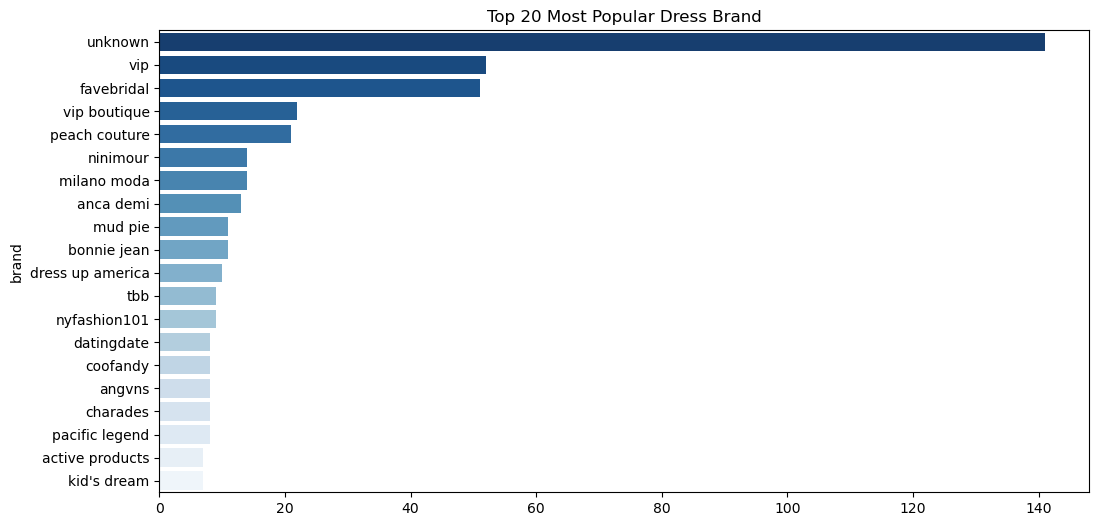

In [99]:
# Count brand frequency
brand_counts = df_dress["brand"].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=brand_counts.values, 
    y=brand_counts.index, 
    palette="Blues_r"
)

plt.title("Top 20 Most Popular Dress Brand")


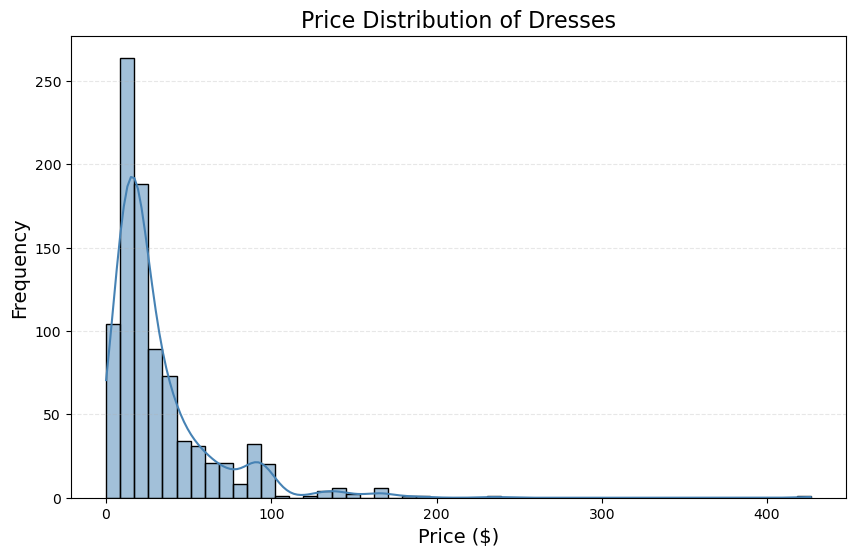

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(
    df_dress["price"], 
    bins=50, 
    kde=True, 
    color="steelblue"
)

plt.title("Price Distribution of Dresses", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()


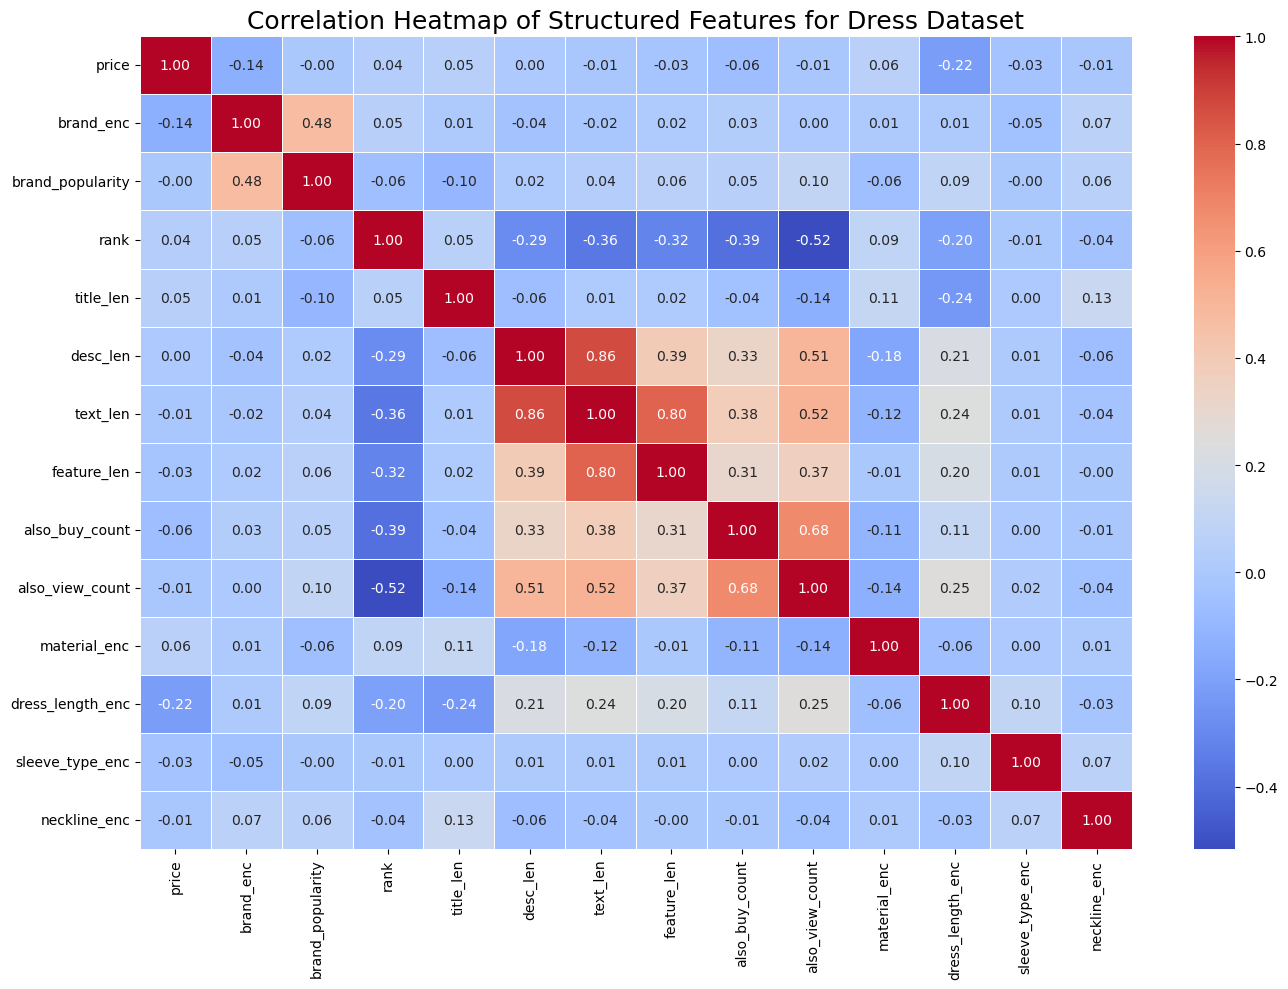

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric structured features
corr_features = [
    "price", "brand_enc", "brand_popularity", "rank",
    "title_len", "desc_len", "text_len", "feature_len",
    "also_buy_count", "also_view_count",
    "material_enc", "dress_length_enc", 
    "sleeve_type_enc", "neckline_enc"
]

corr_matrix = df_dress[corr_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Correlation Heatmap of Structured Features for Dress Dataset", fontsize=18)
plt.tight_layout()
plt.show()


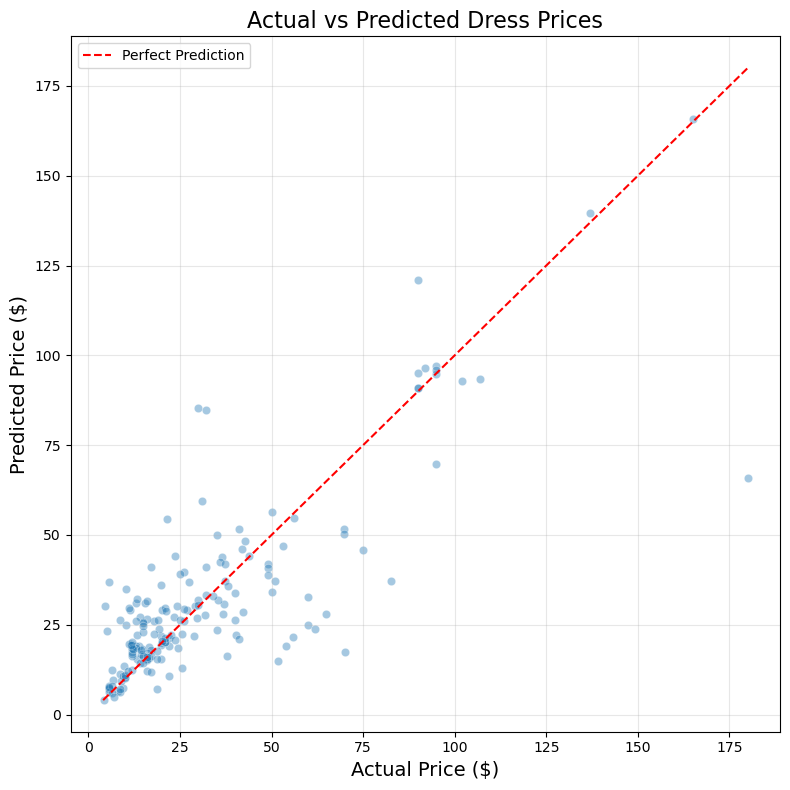

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_test, 
    y=y_pred, 
    alpha=0.4
)

# Add perfect prediction line
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))

plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color="red", 
    linestyle="--", 
    label="Perfect Prediction"
)

plt.title("Actual vs Predicted Dress Prices", fontsize=16)
plt.xlabel("Actual Price ($)", fontsize=14)
plt.ylabel("Predicted Price ($)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


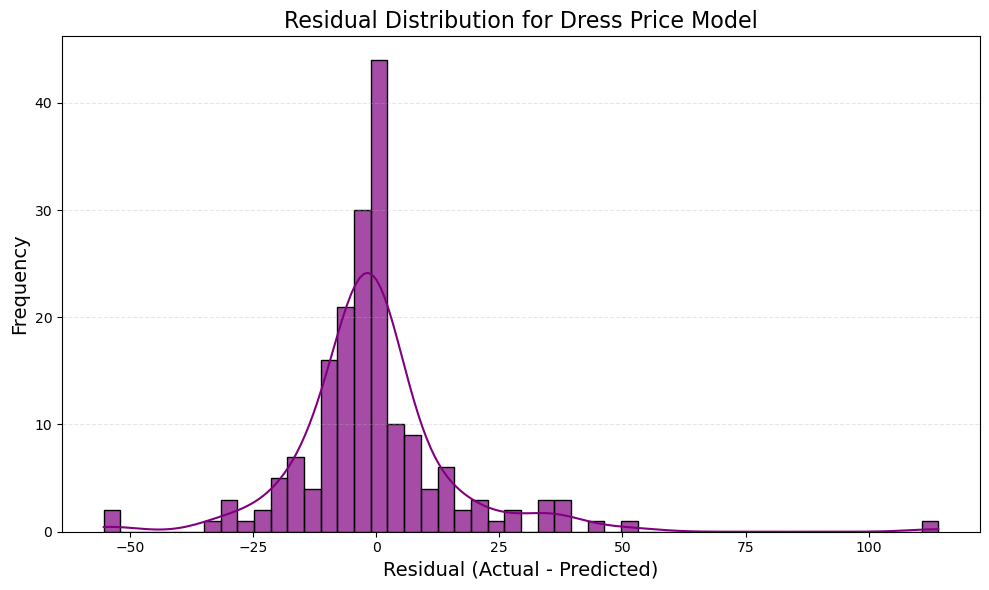

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))

sns.histplot(
    residuals,
    bins=50,
    kde=True,
    color='purple',
    alpha=0.7
)

plt.title("Residual Distribution for Dress Price Model", fontsize=16)
plt.xlabel("Residual (Actual - Predicted)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\prati\AppData\Local\Temp\ipykernel_12380\1022660808.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


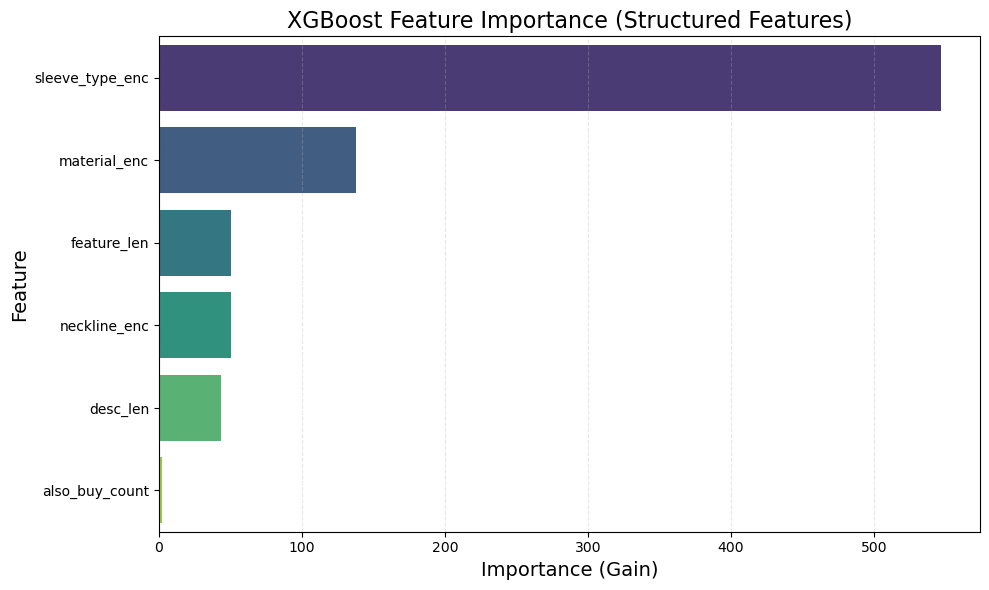

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Get feature importance scores
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Map numeric structured features to their correct names
numeric_feature_names = X_struct.columns.tolist()

# Extract only numeric feature importances from the dict
named_importance = {
    numeric_feature_names[int(k[1:])]: v
    for k, v in importance_dict.items()
    if k.startswith("f") and int(k[1:]) < len(numeric_feature_names)
}

# Convert to sorted list
sorted_features = sorted(named_importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [f[0] for f in sorted_features]
feature_scores = [f[1] for f in sorted_features]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_scores,
    y=feature_names,
    palette="viridis"
)

plt.title("XGBoost Feature Importance (Structured Features)", fontsize=16)
plt.xlabel("Importance (Gain)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [66]:
df_reg = df_meta[[
    "asin", "title", "brand", "brand_enc",
    "rank","brand_popularity", "price","title_len", "desc_len","text_len","feature_len",
    "also_buy_count", "also_view_count",
    "feature", "description", "text"
]].copy()


### Fashion-specific feature engineering

In [69]:
# ---- MATERIAL ----
def detect_material(text):
    text = str(text).lower()
    materials = [
        "cotton","polyester","silk","chiffon","lace","satin",
        "linen","velvet","spandex","rayon","nylon","denim","mesh","wool"
    ]
    for m in materials:
        if m in text:
            return m
    return "other"

df_dress["material"] = df_dress["description"].apply(detect_material)
df_dress["material_enc"] = df_dress["material"].astype("category").cat.codes


In [71]:
# ---- DRESS LENGTH ----
def detect_length(text):
    text = str(text).lower()
    if "maxi" in text: return "maxi"
    if "midi" in text: return "midi"
    if "mini" in text: return "mini"
    if "knee" in text: return "knee"
    if "long" in text: return "long"
    return "other"

df_dress["dress_length"] = df_dress["title"].apply(detect_length)
df_dress["dress_length_enc"] = df_dress["dress_length"].astype("category").cat.codes

In [73]:
# ---- SLEEVE TYPE ----
def detect_sleeve(text):
    text = str(text).lower()
    if "long sleeve" in text: return "long sleeve"
    if "short sleeve" in text: return "short sleeve"
    if "sleeveless" in text: return "sleeveless"
    if "half sleeve" in text: return "half sleeve"
    return "other"

df_dress["sleeve_type"] = df_dress["title"].apply(detect_sleeve)
df_dress["sleeve_type_enc"] = df_dress["sleeve_type"].astype("category").cat.codes


In [75]:
# ---- NECKLINE ----
def detect_neckline(text):
    text = str(text).lower()
    if "v-neck" in text or "v neck" in text: return "v-neck"
    if "round neck" in text or "crew neck" in text: return "round"
    if "off shoulder" in text or "off-shoulder" in text: return "off-shoulder"
    if "halter" in text: return "halter"
    return "other"

df_dress["neckline"] = df_dress["title"].apply(detect_neckline)
df_dress["neckline_enc"] = df_dress["neckline"].astype("category").cat.codes


In [77]:

num_features = ["brand_enc", "brand_popularity","rank", "also_buy_count", "also_view_count","title_len", "desc_len","text_len","feature_len",
                "material_enc", "dress_length_enc","sleeve_type_enc", "neckline_enc"]

X_struct = df_dress[num_features]
y = df_dress["price"]

# Text column (already cleaned)
text_data = df_dress["text"].fillna("")

# Vectorize text
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words="english"
)

X_text = vectorizer.fit_transform(text_data)

# # Combine structured + text features
# X_final = hstack([X_text, X_struct.values])

scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(X_struct)

# Combine structured + text features
X_final = hstack([X_text, X_struct_scaled])

In [79]:
df_dress.head()

,asin,title,brand,brand_enc,brand_popularity,rank,price,feature,description,text,...,category,category_enc,material,material_enc,dress_length,dress_length_enc,sleeve_type,sleeve_type_enc,neckline,neckline_enc
906,B00061TTKK,Girls Sizes 7/8/10/12/14 Embroidered Western D...,astro,284,1,6896424.0,19.990,100% Cotton Denim Dress Shipping Information:\...,nan,Girls Sizes 7/8/10/12/14 Embroidered Western D...,...,dress,5,other,6,other,5,other,2,other,2
3132,B000MWAHWM,Deluxe Mr. Mouse Children's Costume Set By Dre...,dress up america,1168,11,6200476.0,35.950,Polyester Product Comes Complete With: Jacket ...,['Dress up like the most famous mouse of all i...,Deluxe Mr. Mouse Children's Costume Set By Dre...,...,dress,5,polyester,7,other,5,other,2,other,2
3316,B000P0XOWQ,Charades Women's Deluxe Beer Garden Girl Costu...,charades,752,46,1329639.0,41.315,"X-Small, Small, Medium, Large, X-Large Include...",['The delightful Adult Deluxe Beer Garden Lady...,Charades Women's Deluxe Beer Garden Girl Costu...,...,dress,5,other,6,other,5,other,2,other,2
3317,B000P0XOXU,Charades Women's Deluxe Beer Garden Girl Costu...,charades,752,46,1329639.0,41.315,"X-Small, Small, Medium, Large, X-Large Include...",['The delightful Adult Deluxe Beer Garden Lady...,Charades Women's Deluxe Beer Garden Girl Costu...,...,dress,5,other,6,other,5,other,2,other,2
3750,B000V4T9PW,Dress Up America Men's Police Costume Navy Blue,dress up america,1168,11,172222.0,80.195,polyester Flame retardant.Gentle machine washa...,['You won't have to tell any of the bad guys t...,Dress Up America Men's Police Costume Navy Blu...,...,dress,5,polyester,7,other,5,other,2,other,2


# Modelling

# XGBoost Regressor

In [83]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)


In [85]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=9,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.5,
    reg_alpha=1.0,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42
)
# Train
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### Model Evaluation

In [87]:
# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 16.628252635041793
MAE: 9.780939703930866
R²: 0.6617453380479927
